In [1]:
import numpy as np
import os
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K

In [7]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3

EPOCHS=50

In [9]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [10]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [11]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


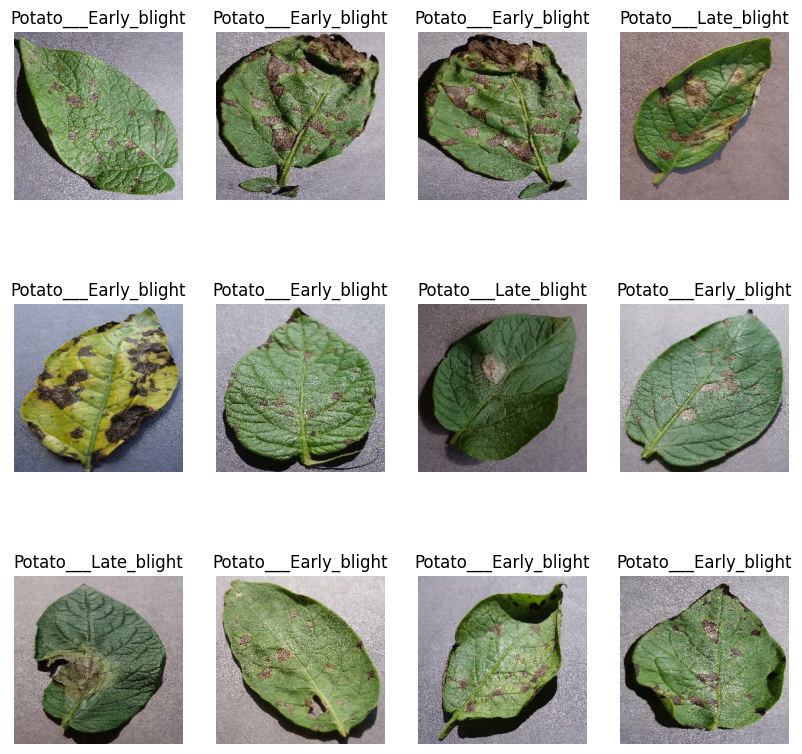

In [12]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [9]:
len(dataset)

68

In [14]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [15]:
train_ds = dataset.take(54)
len(train_ds)

54

In [16]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [13]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [17]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [18]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [19]:
len(train_ds)

54

In [18]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])


In [21]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [21]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)


In [22]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Assuming you have defined BATCH_SIZE, IMAGE_SIZE, CHANNELS
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential()

# Layer 1
model.add(layers.Conv2D(96, kernel_size=(11, 11), strides=(4, 4), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

# Layer 2
model.add(layers.Conv2D(256, kernel_size=(5, 5), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

# Layer 3
model.add(layers.Conv2D(384, kernel_size=(3, 3), padding='same', activation='relu'))

# Layer 4
model.add(layers.Conv2D(384, kernel_size=(3, 3), padding='same', activation='relu'))

# Layer 5
model.add(layers.Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

# Flatten the output for fully connected layers
model.add(layers.Flatten())

# Fully Connected Layers
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dropout(0.5))

# Output layer
model.add(layers.Dense(n_classes, activation='softmax'))
model.build(input_shape=input_shape)

model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2  (None, 30, 30, 96)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 256)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 384)       885120    
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 384)     

In [23]:
model.compile(
    optimizer='rmsprop',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [24]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    
    epochs=50,
)

Epoch 1/50


54/54 [==============================] - 104s 2s/step - loss: 12590.1562 - accuracy: 0.4705 - val_loss: 1.8988 - val_accuracy: 0.4688
Epoch 2/50
54/54 [==============================] - 94s 2s/step - loss: 1.0892 - accuracy: 0.5017 - val_loss: 0.8823 - val_accuracy: 0.5573
Epoch 3/50
54/54 [==============================] - 59s 1s/step - loss: 26.9879 - accuracy: 0.4664 - val_loss: 0.9601 - val_accuracy: 0.4375
Epoch 4/50
54/54 [==============================] - 97s 2s/step - loss: 1.1681 - accuracy: 0.4815 - val_loss: 1.0455 - val_accuracy: 0.4844
Epoch 5/50
54/54 [==============================] - 97s 2s/step - loss: 1.3745 - accuracy: 0.4780 - val_loss: 1.3865 - val_accuracy: 0.4792
Epoch 6/50
54/54 [==============================] - 101s 2s/step - loss: 1.5161 - accuracy: 0.4838 - val_loss: 0.8859 - val_accuracy: 0.4948
Epoch 7/50
54/54 [==============================] - 91s 2s/step - loss: 0.9936 - accuracy: 0.5550 - val_loss: 0.6876 - val_accuracy: 0.7396
Epoch 8/50


In [25]:
scores = model.evaluate(test_ds)

14/14 [==============================] - 8s 392ms/step - loss: 1.0011 - accuracy: 0.8491


In [27]:
scores

[1.0010851621627808, 0.849056601524353]

In [28]:
history

In [29]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [30]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [31]:
type(history.history['loss'])

list

In [32]:
len(history.history['loss'])

50

In [33]:
len(history.history['loss'])

50

In [34]:
history.history['loss'][:5] # show loss for first 5 epochs

[12590.15625,
 1.089232325553894,
 26.987903594970703,
 1.1681432723999023,
 1.374535083770752]

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

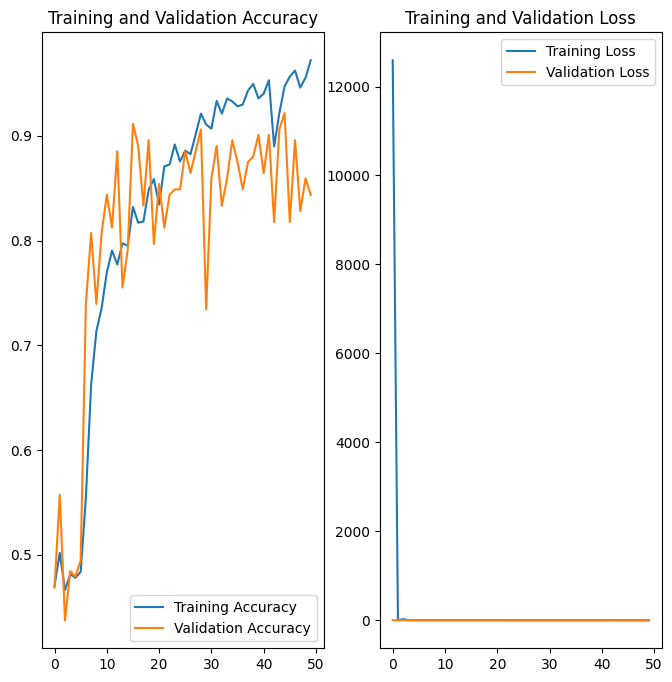

In [36]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 1s 1s/step
predicted label: Potato___Late_blight


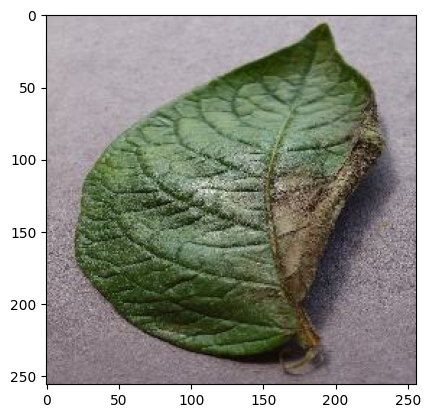

In [37]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [39]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 110ms/step


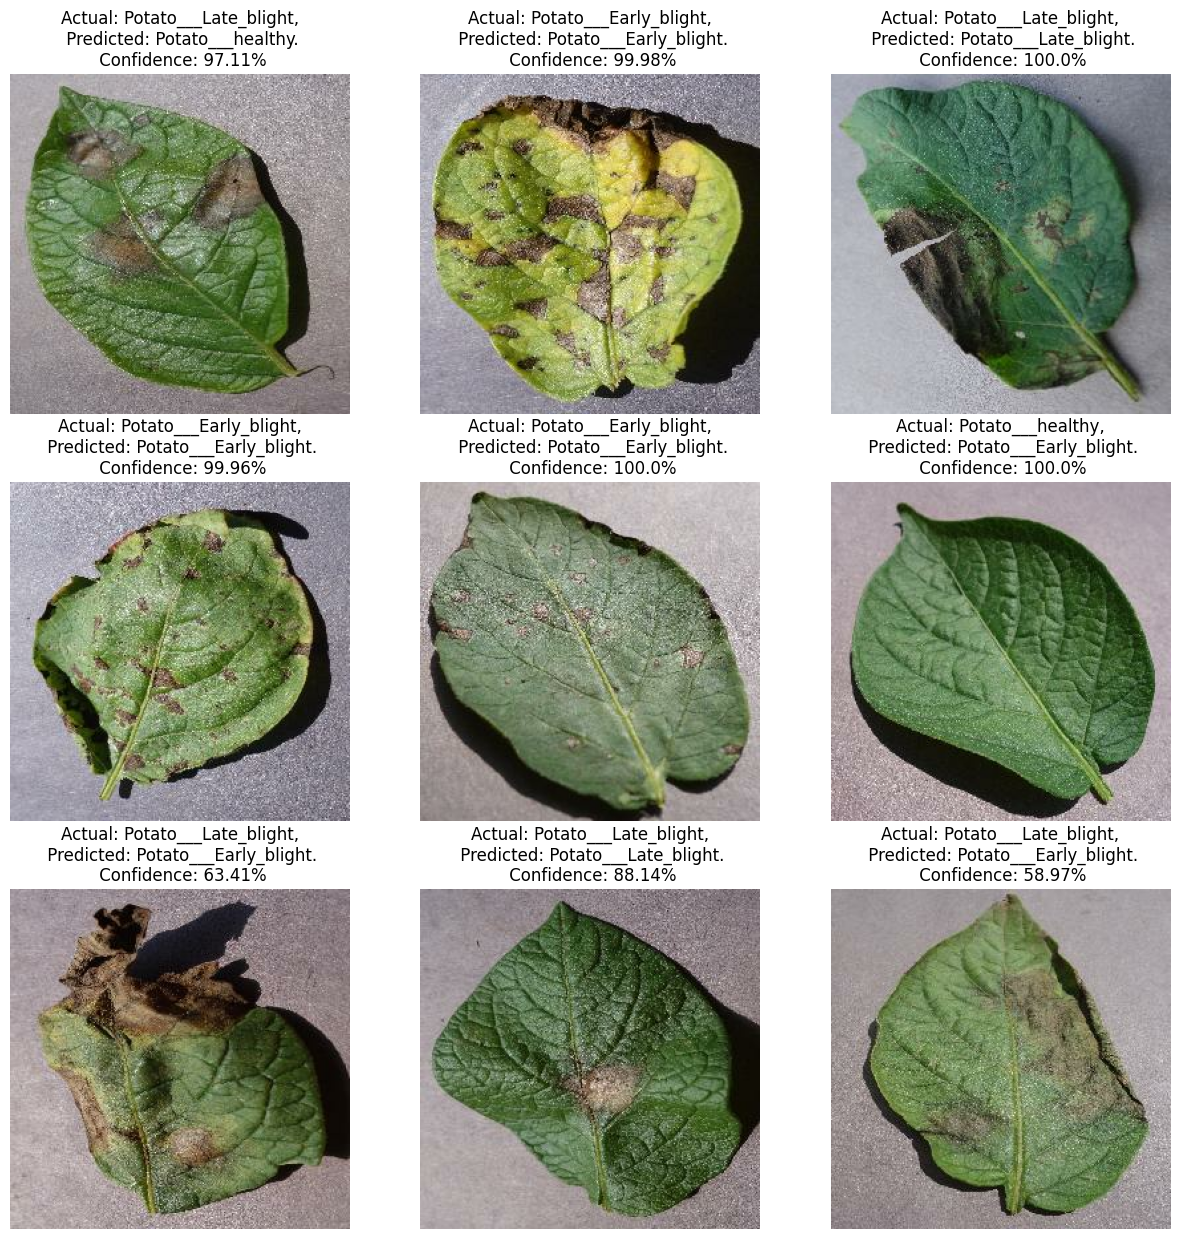

In [40]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [44]:
import os
model_version=max([int(i) for i in os.listdir("../model") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets


In [45]:
model.save("../alexrms.h5")

C:\Users\VNRVJIET\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
